In [27]:
import torch
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import os
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torchvision.datasets import ImageFolder
import seaborn as sns


In [16]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

BASE_PATH = "./"
TRAINED_DATA_DIR = os.path.join(BASE_PATH, 'DATASETS/merged_resized_pngs_splited_augmented/train')
TEST_DATA_DIR = os.path.join(BASE_PATH, 'DATASETS/merged_resized_pngs_splited_augmented/test')
NUM_CLASSES = len(os.listdir(os.path.join(BASE_PATH, f"{TRAINED_DATA_DIR}")))

MODEL_PATH = 'models/MobileNetV2_20240531_021014/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenetv2_base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenetv2_base_model.classifier[1] = nn.Linear(mobilenetv2_base_model.last_channel, 64)
mobilenetv2_base_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
mobilenetv2_base_model.to(device)
mobilenetv2_base_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
test_dataset = ImageFolder(TEST_DATA_DIR, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = os.listdir(os.path.join(BASE_PATH, TRAINED_DATA_DIR))
classes.sort()
classes


['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cherry__healthy',
 'Cherry__powdery_mildew',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Corn__streak_virus',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
 'Soybean__bacterial_blight',
 'Soybean__caterpillar',
 'Soybean__diabrotica_speciosa',
 'Soybean__downy_mildew',
 'Soybean__healthy',
 'Soybean__powdery_mildew',
 'Soybean__rust',
 'Soybean__southern_blight',
 'Strawberry___leaf_scorch',
 'Strawberry__healthy',
 'Sugarcane__bacterial_blight',
 'Sugarcane__healthy',
 'Sugarcane__red_rot

In [18]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenetv2_base_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

In [24]:
# accuracy, precision, recall, f1 score
accuracy = np.trace(cm) / np.sum(cm)
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")


Accuracy: 0.9590459303323229


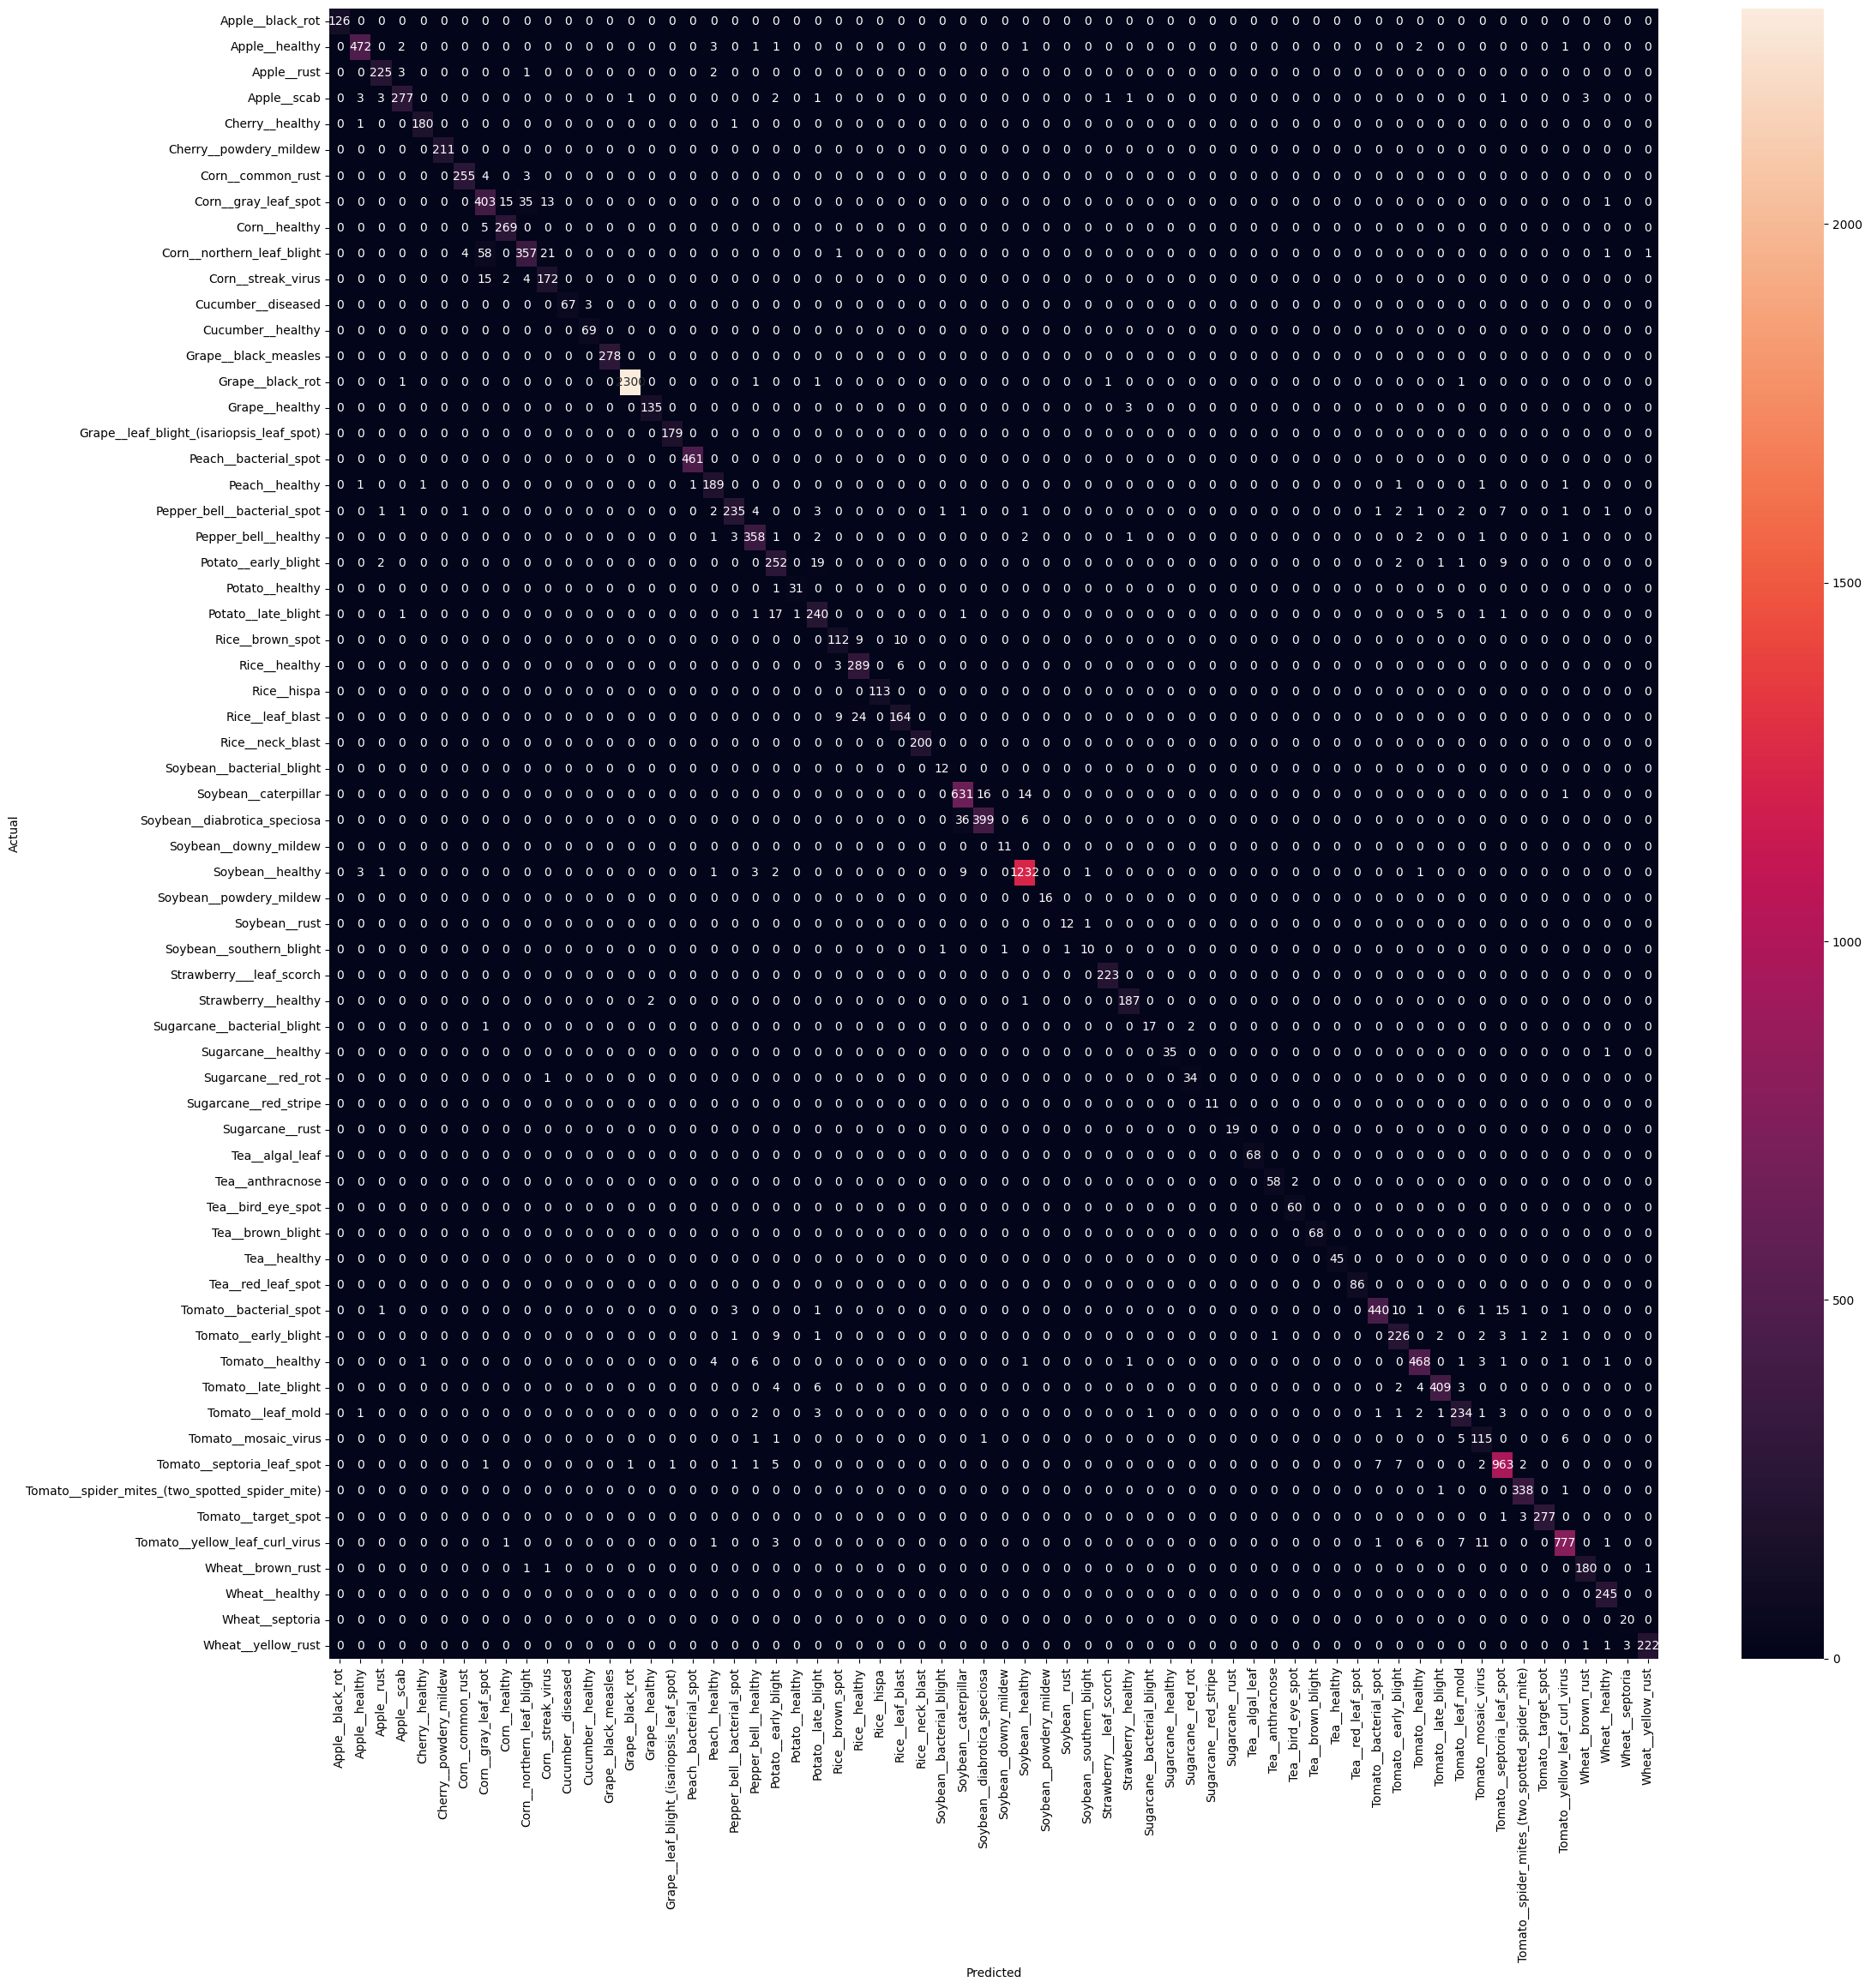

In [26]:
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

                                                precision    recall  f1-score   support

                              Apple__black_rot       1.00      1.00      1.00       126
                                Apple__healthy       0.98      0.98      0.98       483
                                   Apple__rust       0.97      0.97      0.97       231
                                   Apple__scab       0.97      0.95      0.96       293
                               Cherry__healthy       0.99      0.99      0.99       182
                        Cherry__powdery_mildew       1.00      1.00      1.00       211
                             Corn__common_rust       0.98      0.97      0.98       262
                          Corn__gray_leaf_spot       0.83      0.86      0.84       467
                                 Corn__healthy       0.94      0.98      0.96       274
                    Corn__northern_leaf_blight       0.89      0.81      0.85       443
                            Cor

In [39]:
from custom_model import MobilnetWEdittedClassifier

MWEC_MODEL_PATH = 'models/MobilnetWEdittedClassifier_20240531_053141/best_model.pth'
NUM_CLASSES = 64  # Update with the correct number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_with_editted_classifier = MobilnetWEdittedClassifier(num_classes=NUM_CLASSES, num_plant_types=15)
model_with_editted_classifier.load_state_dict(torch.load(MWEC_MODEL_PATH, map_location=device))
model_with_editted_classifier.to(device)
model_with_editted_classifier.eval()


MobilnetWEdittedClassifier(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 9

In [40]:
import yaml

class_names = test_dataset.classes
plant_names = [class_name.split("__")[0] for class_name in class_names]
plant_to_onehot = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)["plant_to_onehot"]
label_to_onehot = {label: plant_to_onehot[plant] for label, plant in enumerate(plant_names)}

def get_plant_types(labels):
    onehot_labels = [label_to_onehot[label.item()] for label in labels.cpu()]
    return torch.tensor(onehot_labels, dtype=torch.float32).to(device)


label_to_onehot

{0: [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 1: [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 2: [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 3: [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 4: [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 5: [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 6: [0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 7: [0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 8: [0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 9: [0.0,
  0.0,
  

In [41]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        plant_types = get_plant_types(labels) # Get one-hot encoded plant types
        outputs = model_with_editted_classifier(images, plant_types)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

In [42]:
# accuracy, precision, recall, f1 score
accuracy = np.trace(cm) / np.sum(cm)
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")


Accuracy: 0.9639077961448264


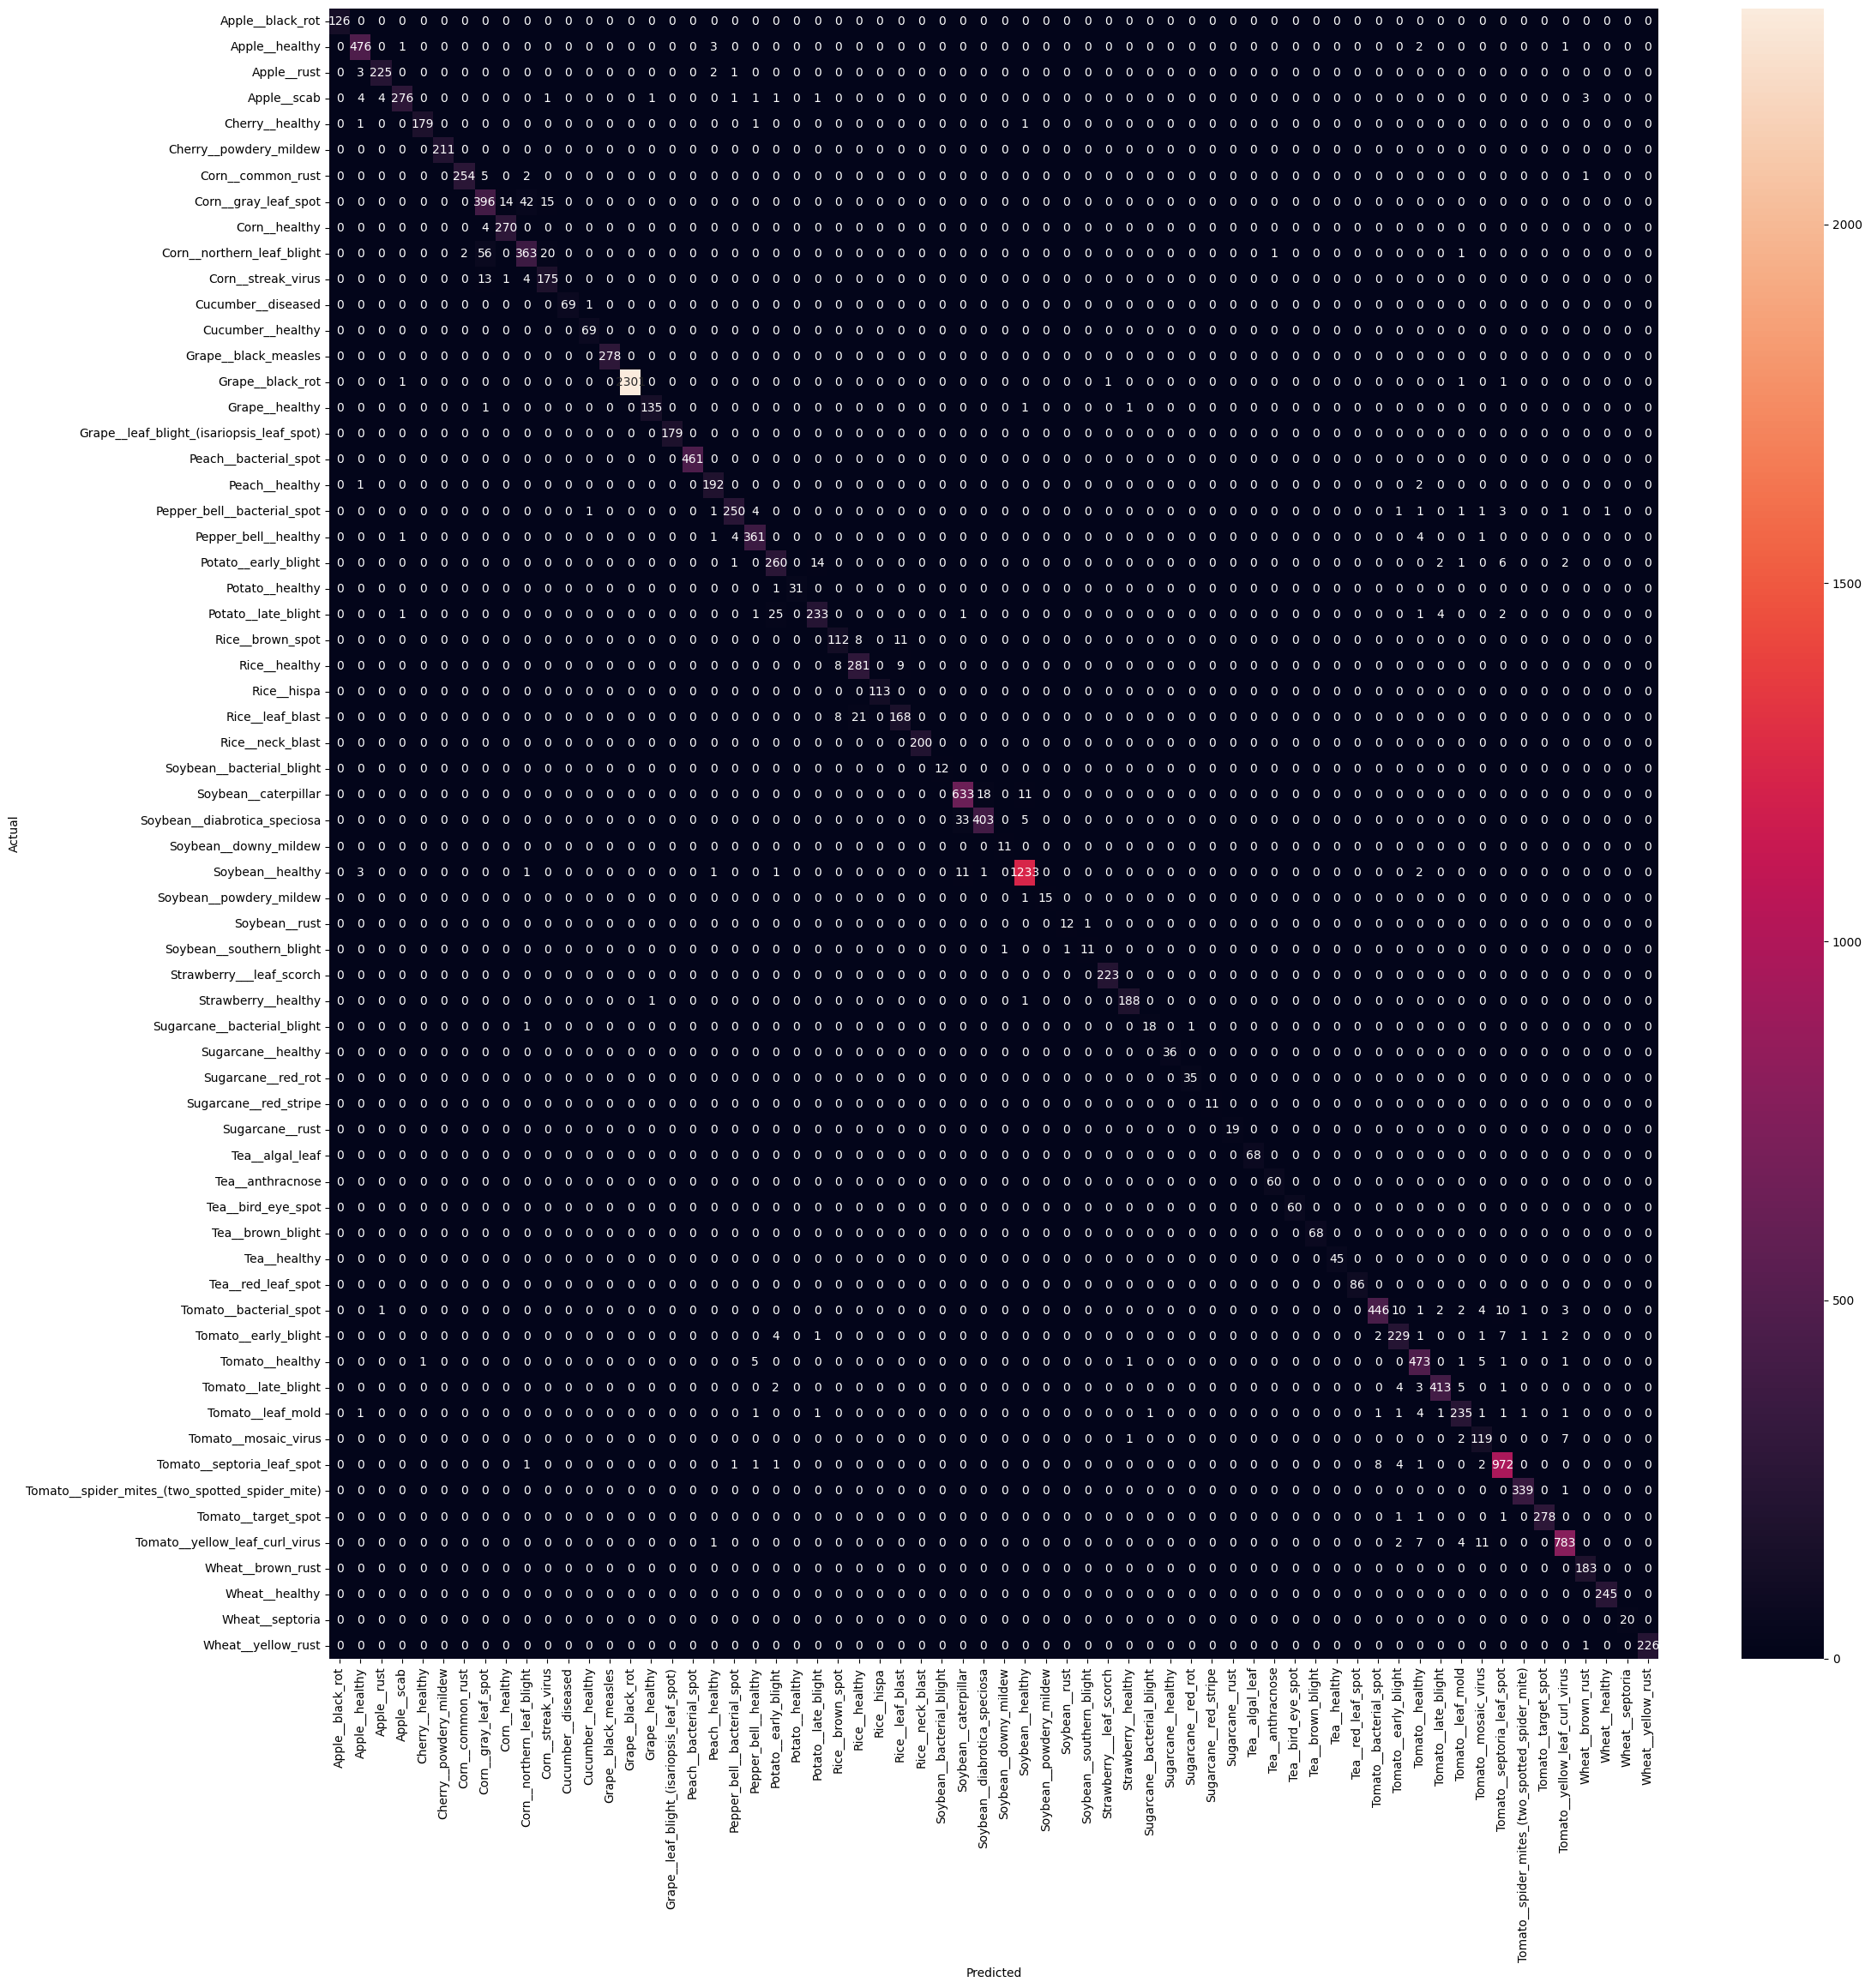

In [43]:
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

                                                precision    recall  f1-score   support

                              Apple__black_rot       1.00      1.00      1.00       126
                                Apple__healthy       0.97      0.99      0.98       483
                                   Apple__rust       0.98      0.97      0.98       231
                                   Apple__scab       0.99      0.94      0.96       293
                               Cherry__healthy       0.99      0.98      0.99       182
                        Cherry__powdery_mildew       1.00      1.00      1.00       211
                             Corn__common_rust       0.99      0.97      0.98       262
                          Corn__gray_leaf_spot       0.83      0.85      0.84       467
                                 Corn__healthy       0.95      0.99      0.97       274
                    Corn__northern_leaf_blight       0.88      0.82      0.85       443
                            Cor

c:\Users\90533\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\90533\AppData\Local\Temp\ipykernel_19120\283519438.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormap)


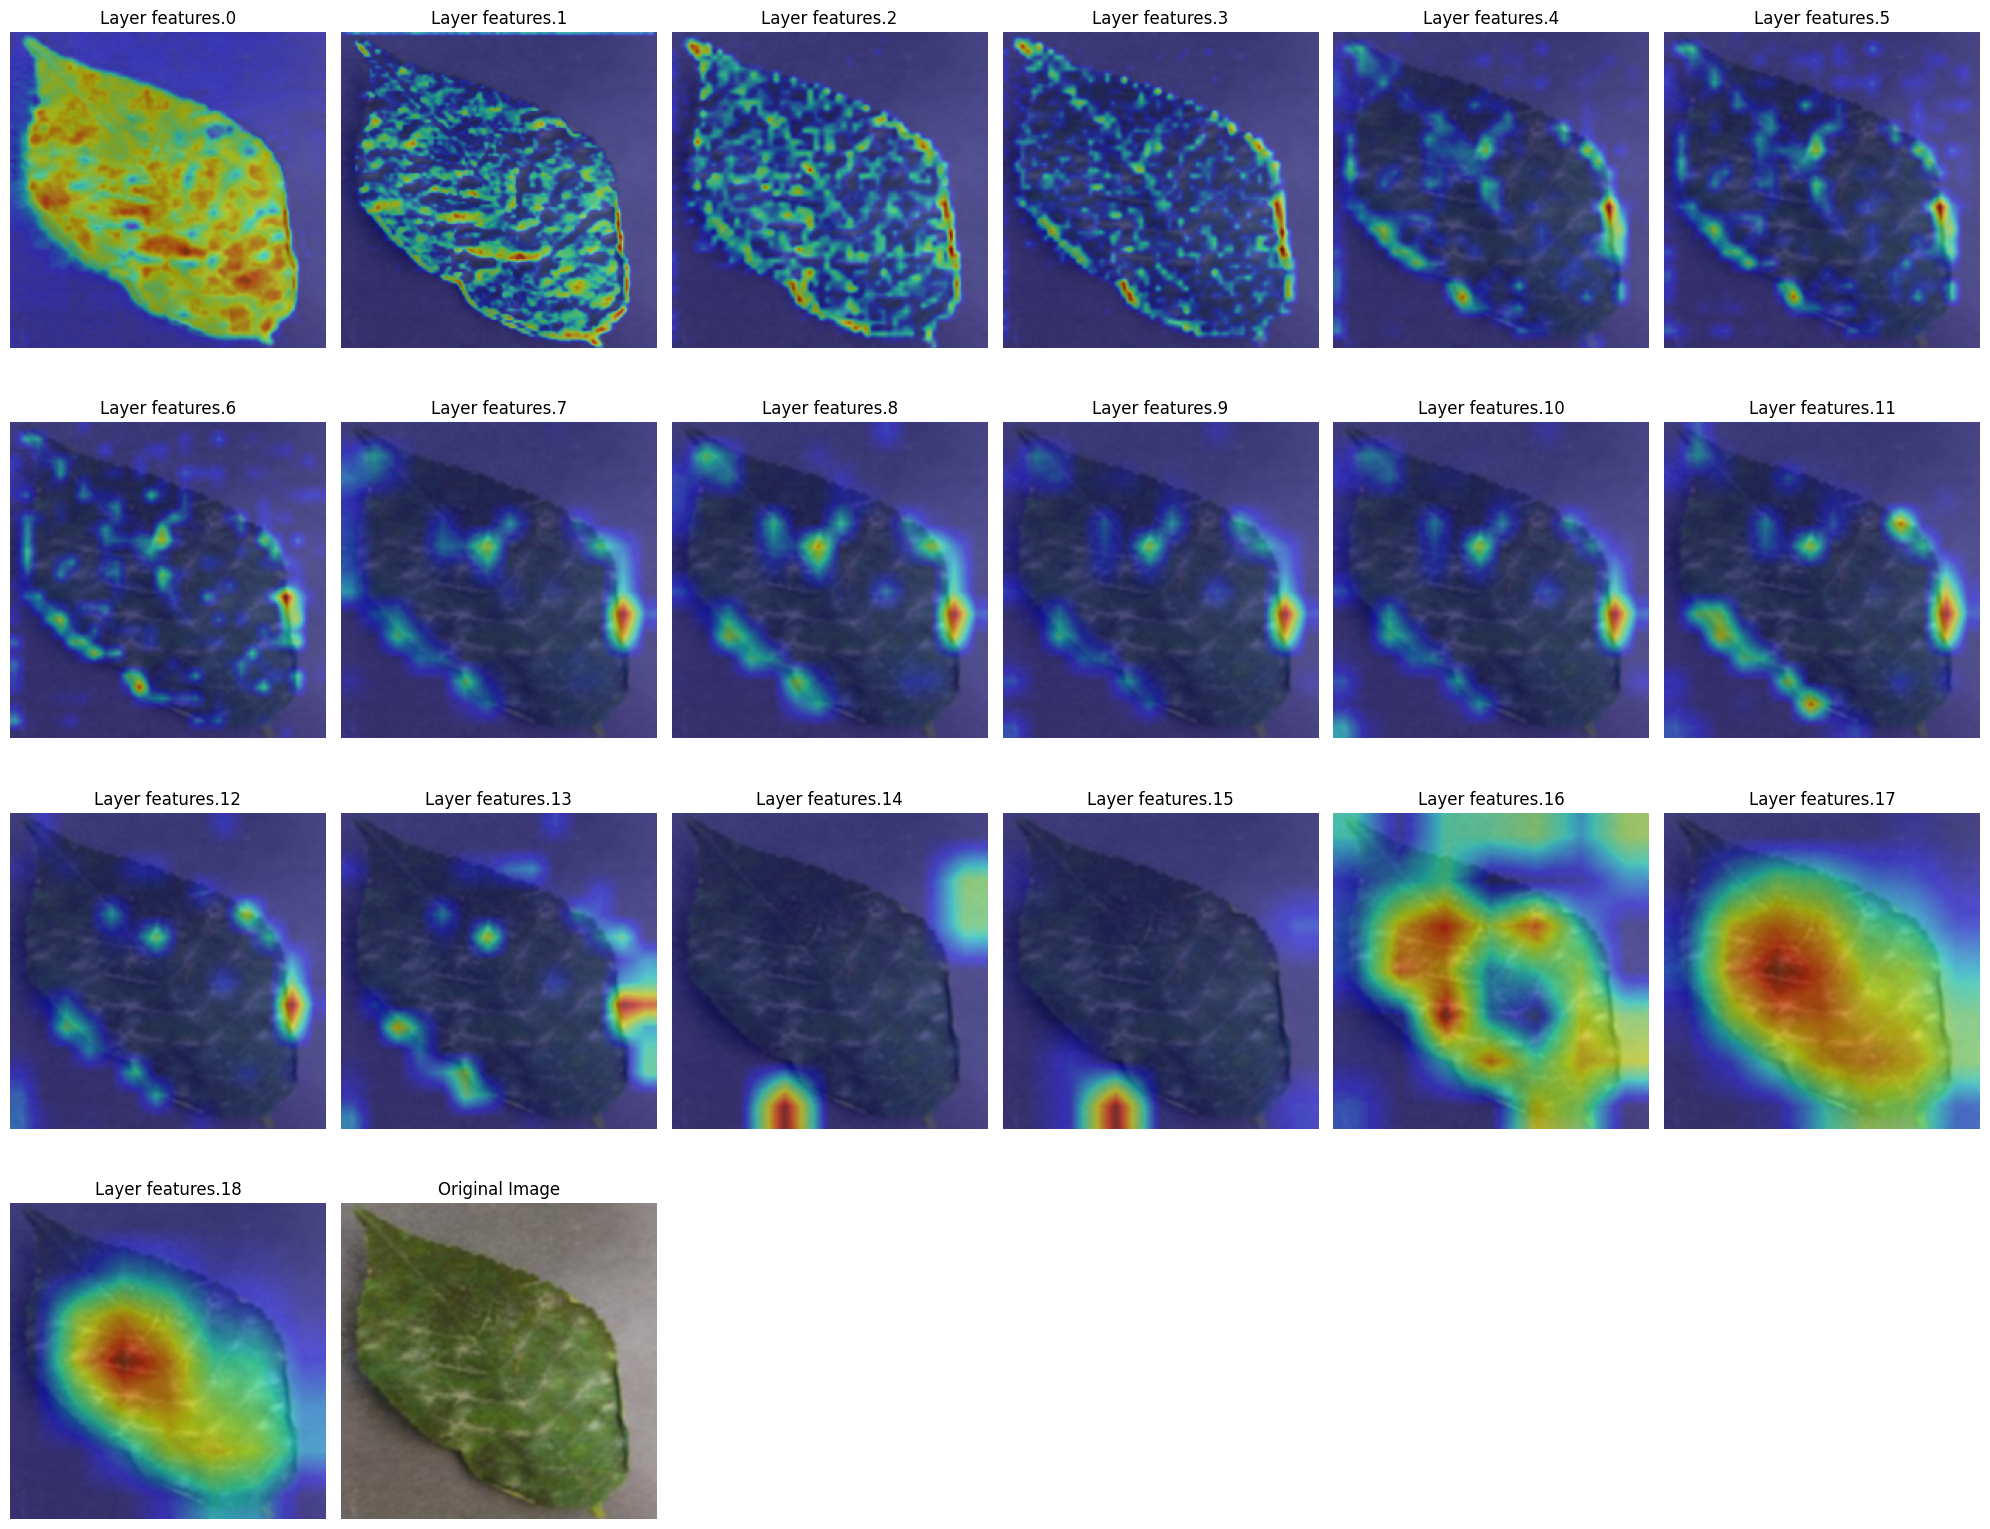

In [45]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_module = dict(self.model.named_modules())[self.target_layer]
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_image, class_idx=None):
        output = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        target = output[0][class_idx]
        target.backward()
        weights = self.gradients.mean(dim=[0, 2, 3], keepdim=True)
        grad_cam = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam = F.relu(grad_cam)
        grad_cam = F.interpolate(grad_cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        grad_cam = grad_cam.squeeze().cpu().numpy()
        heatmap = np.maximum(grad_cam, 0)
        heatmap /= heatmap.max()
        return heatmap

def apply_heatmap(image, heatmap, alpha=0.5, colormap='jet'):
    colormap = plt.cm.get_cmap(colormap)
    heatmap_colored = colormap(heatmap)[:, :, :3]
    heatmap_colored = np.uint8(255 * heatmap_colored)
    overlay = Image.fromarray(heatmap_colored).resize(image.size)
    overlay = np.array(overlay)
    output = np.array(image) * (1 - alpha) + overlay * alpha
    output = np.uint8(output)
    return Image.fromarray(output)

# Modeli ve katman adını belirleyin
MODEL_PATH = 'models/MobileNetV2_20240531_021014/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenetv2_base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenetv2_base_model.classifier[1] = nn.Linear(mobilenetv2_base_model.last_channel, 64)
mobilenetv2_base_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
mobilenetv2_base_model.to(device)

# Örnek resmi yükleyin ve işleyin
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# sample a random image from /example_images dir
sampled_image = np.random.choice(os.listdir('./example_images'))
example_image_path = './example_images/' + sampled_image
image = Image.open(example_image_path).convert('RGB')
input_image = transform(image).unsqueeze(0).to(device)

# Grad-CAM hesapla ve subplot olarak göster
num_layers = len(mobilenetv2_base_model.features)
cols = 6  # Bir satırda gösterilecek sütun sayısı
rows = (num_layers + cols - 1) // cols  # Toplam satır sayısı

plt.figure(figsize=(20, rows * 4))

for i in range(num_layers):
    grad_cam = GradCAM(model=mobilenetv2_base_model, target_layer=f'features.{i}')
    heatmap = grad_cam.generate_heatmap(input_image)
    output_image = apply_heatmap(image, heatmap)

    plt.subplot(rows, cols, i + 1)
    plt.title(f'Layer features.{i}')
    plt.imshow(output_image)
    plt.axis('off')

# Orjinal resmi göster
plt.subplot(rows, cols, num_layers + 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()
